#### Imports

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import visualkeras
import multiprocessing as mp
import subprocess
import numpy as np

2023-05-04 21:27:29.799514: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 21:27:29.853614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 21:27:30.673334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Make keras use gpu (und evtl auch alle Kerne xD)

In [2]:
from keras import backend as K
# tf.config.set_visible_devices([], 'GPU') # für CPU usage
config = tf.compat.v1.ConfigProto(device_count = {'GPU': len(tf.config.list_physical_devices('GPU')), # sollte 1 sein, weil wir nur eine GPU haben
                                                  'CPU': mp.cpu_count()})                             # sollte 64 sein, weil wir 64 CPU Kerne haben
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2023-05-04 21:27:32.574945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78170 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


#### Global Variables

In [3]:
EPOCHS = 30
STEPS_PER_EPOCH = 100
VAL_STEPS = 50
TARGET_SIZE = (150, 150)
BATCH_SIZE = 20

#### Helper Functions

In [4]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'r-', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    return fig

In [5]:
def fit_model(model, train_generator, val_generator):
    history = model.fit(
        train_generator,
        steps_per_epoch= STEPS_PER_EPOCH,
        epochs = EPOCHS,
        validation_data=val_generator,
        validation_steps=VAL_STEPS
    )
    return history

In [6]:
def extract_features(conv_base, directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512)) # FEATURE_EXTRACTION_INPUT_DIM = 4*4*512
    labels = np.zeros(shape=sample_count)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size = BATCH_SIZE,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * BATCH_SIZE : (i+1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i+1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break

    return features, labels

#### Load Datasets

In [7]:
original_dataset_dir = 'data/train'

base_dir = 'data/cats_and_dogs_2k/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

### Baseline Model

In [8]:
def base_model():
    model = tf.keras.models.Sequential()
    # CNN Block 1
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150,150,3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Classification Block
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation= 'relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model
baseline_model = base_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

2023-05-04 21:27:33.203328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78170 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


##### Compile

In [9]:
baseline_model.compile(loss = 'binary_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                       metrics=['acc'])

##### Prepare Data

In [10]:
# NO DATA AUGMENTATION
datagen = test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = datagen.flow_from_directory(validation_dir,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Fit

In [11]:
command = f"python auslastung.py {os.getpid()} 'output/auslastung/baseline.png'"
process = subprocess.Popen(command, shell=True)
baseline_history = fit_model(baseline_model, train_gen, val_gen)
process.wait()

Epoch 1/30


2023-05-04 21:27:35.212948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-04 21:27:37.401616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-04 21:27:38.122944: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-04 21:27:38.231521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-04 21:27:38.236938: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55fdd3990ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 21:27:38.236997: I tensorflo

100/100 [==============================] - ETA: 0s - loss: 0.6937 - acc: 0.5075

2023-05-04 21:27:42.543037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 9s 52ms/step - loss: 0.6937 - acc: 0.5075 - val_loss: 0.6872 - val_acc: 0.5640
Epoch 2/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6859 - acc: 0.5395 - val_loss: 0.6825 - val_acc: 0.5260
Epoch 3/30
100/100 [==============================] - 5s 52ms/step - loss: 0.6771 - acc: 0.5735 - val_loss: 0.6761 - val_acc: 0.5850
Epoch 4/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6710 - acc: 0.5935 - val_loss: 0.6643 - val_acc: 0.5950
Epoch 5/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6615 - acc: 0.6050 - val_loss: 0.6657 - val_acc: 0.5770
Epoch 6/30
100/100 [==============================] - 5s 49ms/step - loss: 0.6523 - acc: 0.6010 - val_loss: 0.6643 - val_acc: 0.5710
Epoch 7/30
100/100 [==============================] - 5s 52ms/step - loss: 0.6441 - acc: 0.6275 - val_loss: 0.6647 - val_acc: 0.5880
Epoch 8/30
100/100 [==============================] - 5s 50ms/step - loss: 0.635

0

##### Plot & Save Results

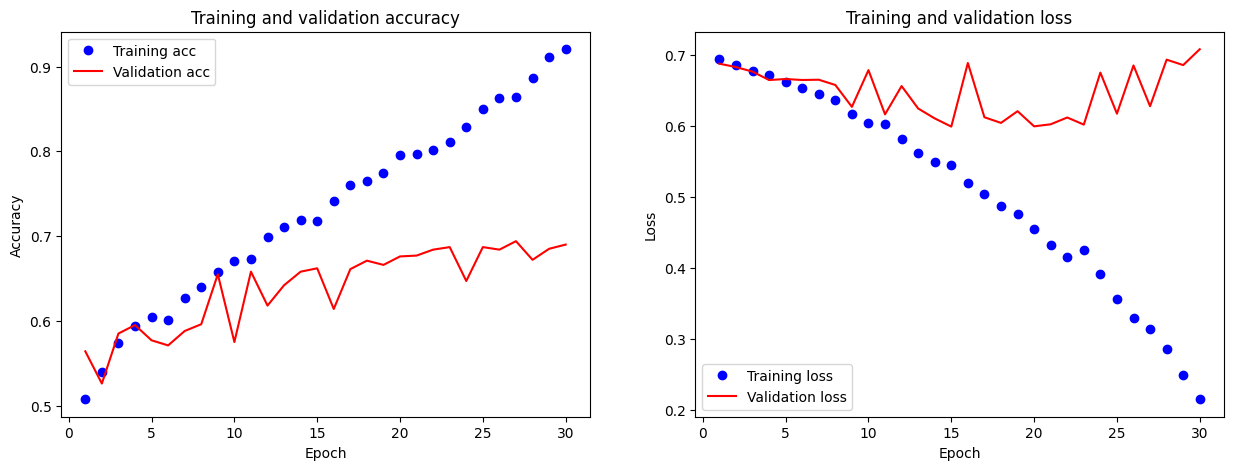

In [12]:
baseline_fig = plot_history(baseline_history)
baseline_fig.savefig('output/plots/baseline_history.png')
baseline_model.save('output/models/baseline_model.h5')

##### Visualized Base Model

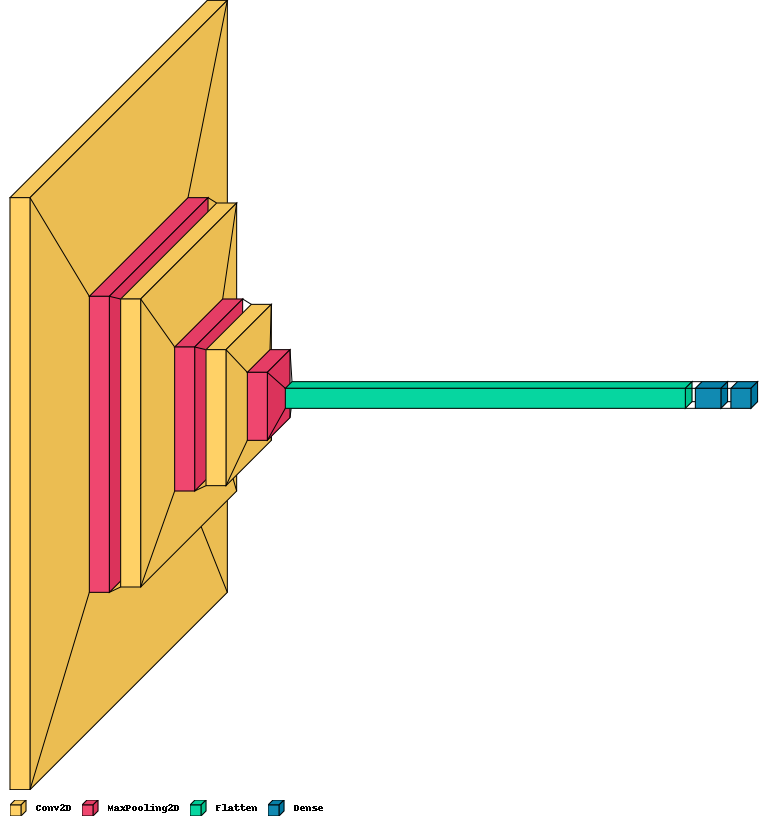

In [13]:
visualkeras.layered_view(baseline_model, legend=True).show()

##### Conclusion
Really strong overfitting, as there is no data augmentation or Dropouts

### Baseline Model with Augmented Data

In [14]:
baseline_ag_model = base_model()

##### Compile

In [15]:
baseline_ag_model.compile(loss = 'binary_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                       metrics=['acc'])

##### Prepare Data

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True
                                                             )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(train_dir,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = test_datagen.flow_from_directory(validation_dir,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Fit

In [17]:
command = f"python auslastung.py {os.getpid()} 'output/auslastung/baseline_ag.png'"
process = subprocess.Popen(command, shell=True)
baseline_ag_history = fit_model(baseline_ag_model, train_gen, val_gen)
process.wait()

Epoch 1/30


2023-05-04 21:30:16.080173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.6922 - acc: 0.5060

2023-05-04 21:30:27.255963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 13s 121ms/step - loss: 0.6922 - acc: 0.5060 - val_loss: 0.6882 - val_acc: 0.5090
Epoch 2/30
100/100 [==============================] - 12s 121ms/step - loss: 0.6888 - acc: 0.5430 - val_loss: 0.6842 - val_acc: 0.5750
Epoch 3/30
100/100 [==============================] - 12s 120ms/step - loss: 0.6870 - acc: 0.5460 - val_loss: 0.6801 - val_acc: 0.5800
Epoch 4/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6837 - acc: 0.5565 - val_loss: 0.6811 - val_acc: 0.5110
Epoch 5/30
100/100 [==============================] - 11s 113ms/step - loss: 0.6797 - acc: 0.5815 - val_loss: 0.6714 - val_acc: 0.5720
Epoch 6/30
100/100 [==============================] - 12s 122ms/step - loss: 0.6771 - acc: 0.5750 - val_loss: 0.6662 - val_acc: 0.6030
Epoch 7/30
100/100 [==============================] - 12s 122ms/step - loss: 0.6708 - acc: 0.5790 - val_loss: 0.6605 - val_acc: 0.6010
Epoch 8/30
100/100 [==============================] - 12s 115ms/st

0

##### Plot & Save Results

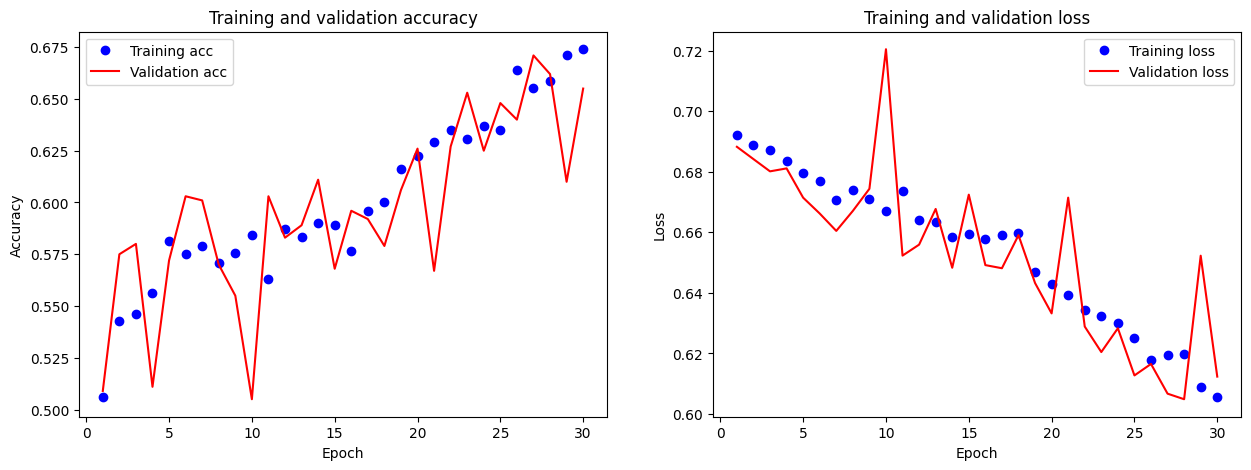

In [18]:
baseline_ag_fig = plot_history(baseline_ag_history)
baseline_ag_fig.savefig('output/plots/baseline_ag_history.png')
baseline_ag_model.save('output/models/baseline_ag_model.h5')

##### Conclusion

Nomore overfitting, but the accuracy for the training got worse.

### Feature Extraction

In [19]:
FEATURE_EXTRACTION_INPUT_DIM = 4*4*512

In [20]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

##### Extract Train, Val and Test

In [21]:
train_features, train_labels = extract_features(conv_base, train_dir, 2000)
validation_features, validation_labels = extract_features(conv_base, validation_dir, 1000)
test_features, test_labels = extract_features(conv_base, test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 30ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 30ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 30ms/step


##### Reshape

In [22]:
train_features = np.reshape(train_features, (2000, FEATURE_EXTRACTION_INPUT_DIM))
validation_features = np.reshape(validation_features, (1000, FEATURE_EXTRACTION_INPUT_DIM))
test_featues = np.reshape(test_features, (1000, FEATURE_EXTRACTION_INPUT_DIM))

In [23]:
def feature_extraction_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=FEATURE_EXTRACTION_INPUT_DIM))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

fe_model = feature_extraction_model()

##### Compile

In [24]:
fe_model.compile(loss = 'binary_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                 metrics=['acc'])

##### Fitting

In [25]:
def fit_fe_model():
    fe_model_history = fe_model.fit(train_features, train_labels,
                                    steps_per_epoch=STEPS_PER_EPOCH,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(validation_features, validation_labels), 
                                    validation_steps=VAL_STEPS)
    return fe_model_history

In [26]:
command = f"python auslastung.py {os.getpid()} 'output/auslastung/fe_model.png'"
process = subprocess.Popen(command, shell=True)
fe_model_history = fit_fe_model()
process.wait()

Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.4470 - acc: 0.7710 - val_loss: 0.3828 - val_acc: 0.8150
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3307 - acc: 0.8555 - val_loss: 0.3144 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2702 - acc: 0.8875 - val_loss: 0.2682 - val_acc: 0.8910
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2596 - acc: 0.8935 - val_loss: 0.2557 - val_acc: 0.9070
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2087 - acc: 0.9200 - val_loss: 0.3122 - val_acc: 0.8660
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2116 - acc: 0.9160 - val_loss: 0.2436 - val_acc: 0.9060
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1795 - acc: 0.9295 - val_loss: 0.3825 - val_acc: 0.8310
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

0

##### Plots

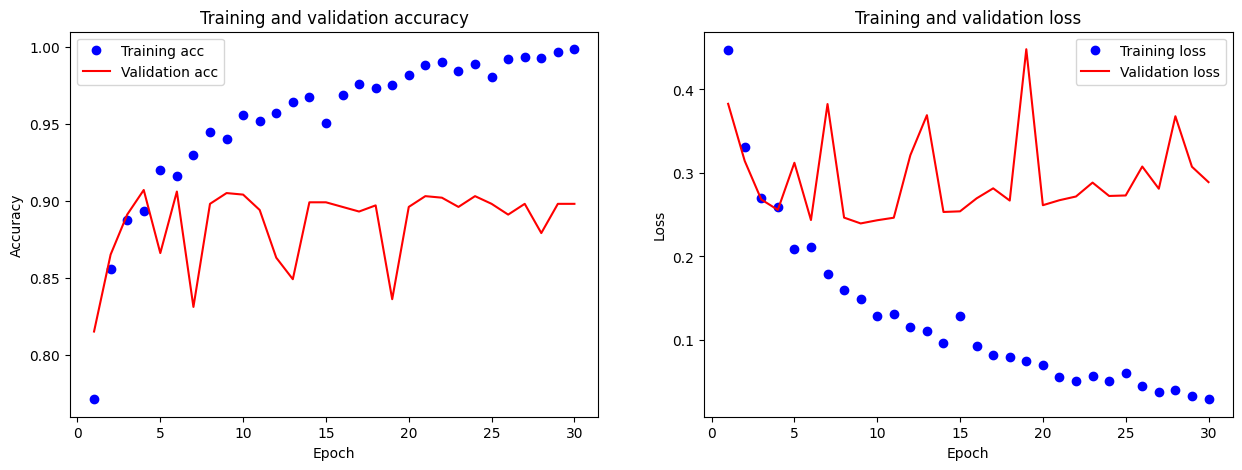

In [27]:
fe_model_fig = plot_history(fe_model_history)
fe_model_fig.savefig('output/plots/feature_extracted_history.png')
fe_model.save('output/models/feature_extracted_model.h5')

##### Conclusion

The model overfits quite a bit, similar to my first model. But not as much, maybe with fine tuning this overfitting can be solved.

### Fine Tuned Model

In [28]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

##### Define Model
The VGG16 base connects to a Flattener, then a MLP (Multilayer Perceptron), with a Dropout of 50%

In [29]:
def fine_tuning_model():
    model = tf.keras.models.Sequential()
    model.add(conv_base)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.summary()
    return model
fine_tune_model = fine_tuning_model()
fine_tune_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
____________________

##### Compile

In [30]:
fine_tune_model.compile(loss = 'binary_crossentropy',
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                        metrics=['acc'])

##### Prepare Data

In [31]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True
                                                             )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(train_dir,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = test_datagen.flow_from_directory(validation_dir,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### First Fitting with no Fine Tune

In [33]:
def no_ft_model():
    no_ft_history = fine_tune_model.fit(
        train_gen,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data= val_gen,
        validation_steps=VAL_STEPS
    )
    return no_ft_history

In [34]:
command = f"python auslastung.py {os.getpid()} 'output/auslastung/no_fine_tuned_model.png'"
process = subprocess.Popen(command, shell=True)
no_ft_history = no_ft_model()
process.wait()

Epoch 1/30


2023-05-04 21:40:21.550022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.5438 - acc: 0.6985

2023-05-04 21:40:34.827113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 15s 121ms/step - loss: 0.5438 - acc: 0.6985 - val_loss: 0.2140 - val_acc: 0.9130
Epoch 2/30
100/100 [==============================] - 12s 120ms/step - loss: 0.3042 - acc: 0.8720 - val_loss: 0.1712 - val_acc: 0.9340
Epoch 3/30
100/100 [==============================] - 12s 119ms/step - loss: 0.2389 - acc: 0.9005 - val_loss: 0.1351 - val_acc: 0.9510
Epoch 4/30
100/100 [==============================] - 12s 118ms/step - loss: 0.1969 - acc: 0.9210 - val_loss: 0.1662 - val_acc: 0.9350
Epoch 5/30
100/100 [==============================] - 12s 119ms/step - loss: 0.1998 - acc: 0.9190 - val_loss: 0.1469 - val_acc: 0.9460
Epoch 6/30
100/100 [==============================] - 12s 121ms/step - loss: 0.1487 - acc: 0.9380 - val_loss: 0.0955 - val_acc: 0.9610
Epoch 7/30
100/100 [==============================] - 12s 118ms/step - loss: 0.1514 - acc: 0.9390 - val_loss: 0.1283 - val_acc: 0.9570
Epoch 8/30
100/100 [==============================] - 12s 119ms/st

0

##### Freeze <code>conv_base</code> first 4 Blocks and unfreeze Block 5

In [35]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        print(f'Unfreezing {layer.name} layer')
        set_trainable = True
    if set_trainable:
        print(f'Unfreezing {layer.name} layer')
        layer.trainable = True
    else:
        print(f'Freezing {layer.name} layer')
        layer.trainable = False

Freezing input_2 layer
Freezing block1_conv1 layer
Freezing block1_conv2 layer
Freezing block1_pool layer
Freezing block2_conv1 layer
Freezing block2_conv2 layer
Freezing block2_pool layer
Freezing block3_conv1 layer
Freezing block3_conv2 layer
Freezing block3_conv3 layer
Freezing block3_pool layer
Freezing block4_conv1 layer
Freezing block4_conv2 layer
Freezing block4_conv3 layer
Freezing block4_pool layer
Unfreezing block5_conv1 layer
Unfreezing block5_conv1 layer
Unfreezing block5_conv2 layer
Unfreezing block5_conv3 layer
Unfreezing block5_pool layer


##### Recompile Model

In [36]:
fine_tune_model.compile(loss = 'binary_crossentropy',
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                        metrics=['acc'])

##### Refit Model

In [37]:
def fit_finetuned_model():
    ft_history = fine_tune_model.fit(
        train_gen,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data= val_gen,
        validation_steps=VAL_STEPS
    )
    return ft_history

In [38]:
command = f"python auslastung.py {os.getpid()} 'output/auslastung/fine_tuned_model.png'"
process = subprocess.Popen(command, shell=True)
ft_history = fit_finetuned_model()
process.wait()

Epoch 1/30


2023-05-04 21:46:28.440139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.0188 - acc: 0.9940

2023-05-04 21:46:39.913463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 13s 123ms/step - loss: 0.0188 - acc: 0.9940 - val_loss: 0.0713 - val_acc: 0.9790
Epoch 2/30
100/100 [==============================] - 12s 120ms/step - loss: 0.0167 - acc: 0.9940 - val_loss: 0.0902 - val_acc: 0.9740
Epoch 3/30
100/100 [==============================] - 12s 118ms/step - loss: 0.0226 - acc: 0.9920 - val_loss: 0.0914 - val_acc: 0.9690
Epoch 4/30
100/100 [==============================] - 12s 118ms/step - loss: 0.0227 - acc: 0.9925 - val_loss: 0.0821 - val_acc: 0.9790
Epoch 5/30
100/100 [==============================] - 12s 119ms/step - loss: 0.0167 - acc: 0.9965 - val_loss: 0.0759 - val_acc: 0.9760
Epoch 6/30
100/100 [==============================] - 12s 118ms/step - loss: 0.0200 - acc: 0.9935 - val_loss: 0.1158 - val_acc: 0.9690
Epoch 7/30
100/100 [==============================] - 12s 118ms/step - loss: 0.0098 - acc: 0.9970 - val_loss: 0.0698 - val_acc: 0.9760
Epoch 8/30
100/100 [==============================] - 12s 120ms/st

0

No Finetuning Plot

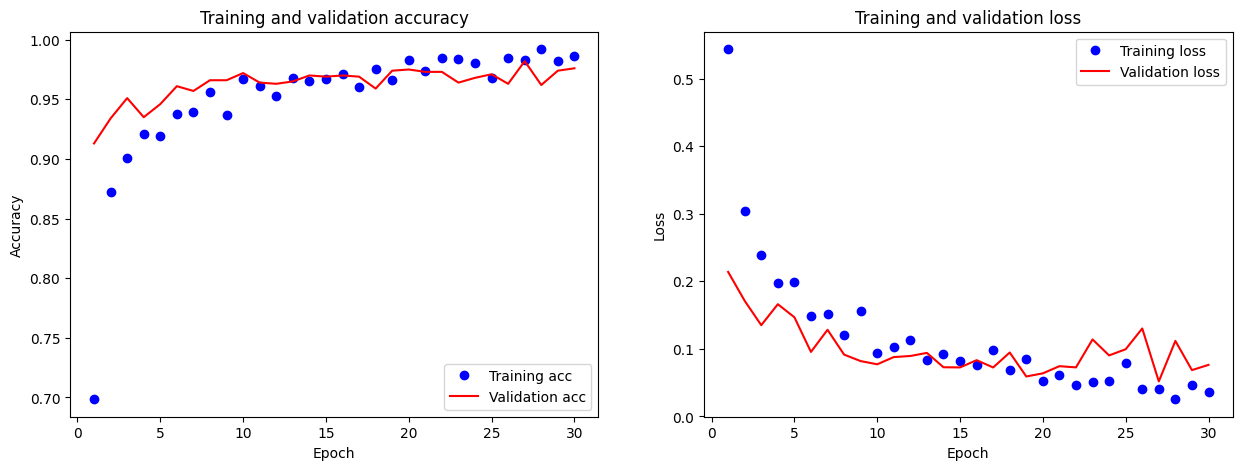

In [39]:
no_ft_model_fig = plot_history(no_ft_history)

Finetuned Plot

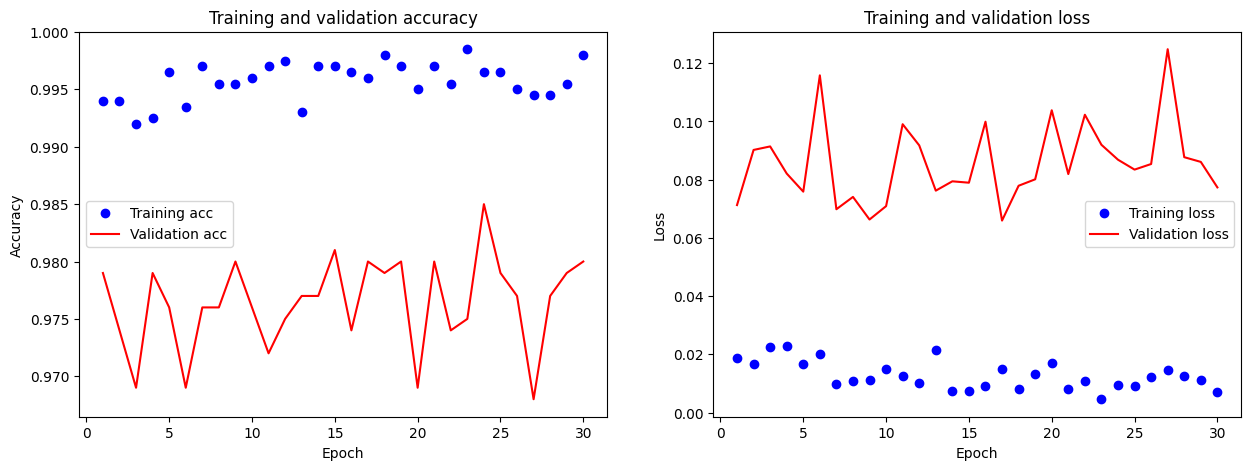

In [40]:
ft_model_fig = plot_history(ft_history)

### 6k anstatt 2k

In [56]:
original_dataset_dir = 'data/train'

base_dir = 'data/cats_and_dogs_6k/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [57]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True
                                                             )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(train_dir,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = test_datagen.flow_from_directory(validation_dir,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [66]:
def base_model():
    model = tf.keras.models.Sequential()
    # CNN Block 1
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150,150,3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Classification Block
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation= 'relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [67]:
base_model_6k = base_model()
base_model_6k.compile(loss = 'binary_crossentropy',
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['acc'])

In [68]:
command = f"python auslastung.py {os.getpid()} 'output/auslastung/6k_baseline_ag.png'"
process = subprocess.Popen(command, shell=True)
baseline_ag_history_6k = fit_model(base_model_6k, train_gen, val_gen)
process.wait()

Epoch 1/30


2023-05-04 23:31:34.200457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.6956 - acc: 0.5265

2023-05-04 23:31:45.082171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 13s 119ms/step - loss: 0.6956 - acc: 0.5265 - val_loss: 0.7059 - val_acc: 0.4820
Epoch 2/30
100/100 [==============================] - 12s 120ms/step - loss: 0.6897 - acc: 0.5450 - val_loss: 0.6803 - val_acc: 0.5550
Epoch 3/30
100/100 [==============================] - 12s 121ms/step - loss: 0.6871 - acc: 0.5420 - val_loss: 0.6756 - val_acc: 0.5600
Epoch 4/30
100/100 [==============================] - 12s 121ms/step - loss: 0.6836 - acc: 0.5580 - val_loss: 0.6777 - val_acc: 0.5630
Epoch 5/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6828 - acc: 0.5535 - val_loss: 0.6861 - val_acc: 0.5150
Epoch 6/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6760 - acc: 0.5905 - val_loss: 0.6694 - val_acc: 0.6060
Epoch 7/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6834 - acc: 0.5465 - val_loss: 0.6767 - val_acc: 0.5670
Epoch 8/30
100/100 [==============================] - 12s 121ms/st

0

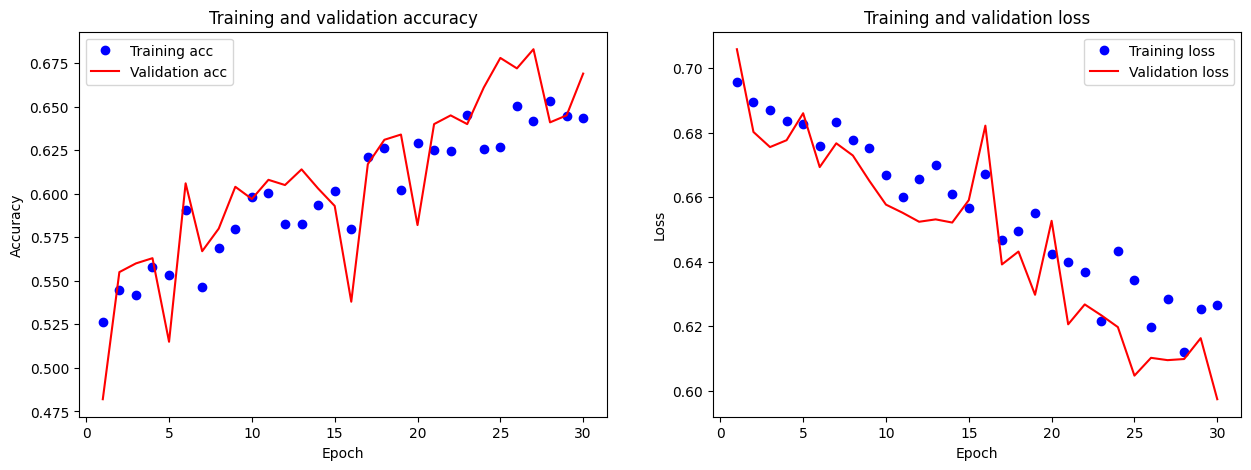

In [69]:
plot_history(baseline_ag_history_6k).savefig('output/plots/6k_baseline_ag_history.png')

### 6k with additional layer

In [74]:
def base_model():
    model = tf.keras.models.Sequential()
    # CNN Block 1
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150,150,3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 4
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Classification Block
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation= 'relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [75]:
base_model_6k = base_model()
base_model_6k.compile(loss = 'binary_crossentropy',
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['acc'])

In [76]:
EPOCHS = 100
command = f"python auslastung.py {os.getpid()} 'output/auslastung/6k_baseline_ag_additional_layer.png'"
process = subprocess.Popen(command, shell=True)
baseline_ag_history_6k_add = fit_model(base_model_6k, train_gen, val_gen)
process.wait()
EPOCHS = 30

Epoch 1/100


2023-05-04 23:48:55.334993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.6938 - acc: 0.4990

2023-05-04 23:49:06.577882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 13s 120ms/step - loss: 0.6938 - acc: 0.4990 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 2/100
100/100 [==============================] - 12s 118ms/step - loss: 0.6926 - acc: 0.5080 - val_loss: 0.6943 - val_acc: 0.4910
Epoch 3/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6921 - acc: 0.5175 - val_loss: 0.6881 - val_acc: 0.5320
Epoch 4/100
100/100 [==============================] - 12s 118ms/step - loss: 0.6899 - acc: 0.5300 - val_loss: 0.6872 - val_acc: 0.5190
Epoch 5/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6903 - acc: 0.5250 - val_loss: 0.6855 - val_acc: 0.5630
Epoch 6/100
100/100 [==============================] - 12s 118ms/step - loss: 0.6894 - acc: 0.5360 - val_loss: 0.6858 - val_acc: 0.5190
Epoch 7/100
100/100 [==============================] - 12s 118ms/step - loss: 0.6861 - acc: 0.5740 - val_loss: 0.6818 - val_acc: 0.5700
Epoch 8/100
100/100 [==============================] - 12s 1

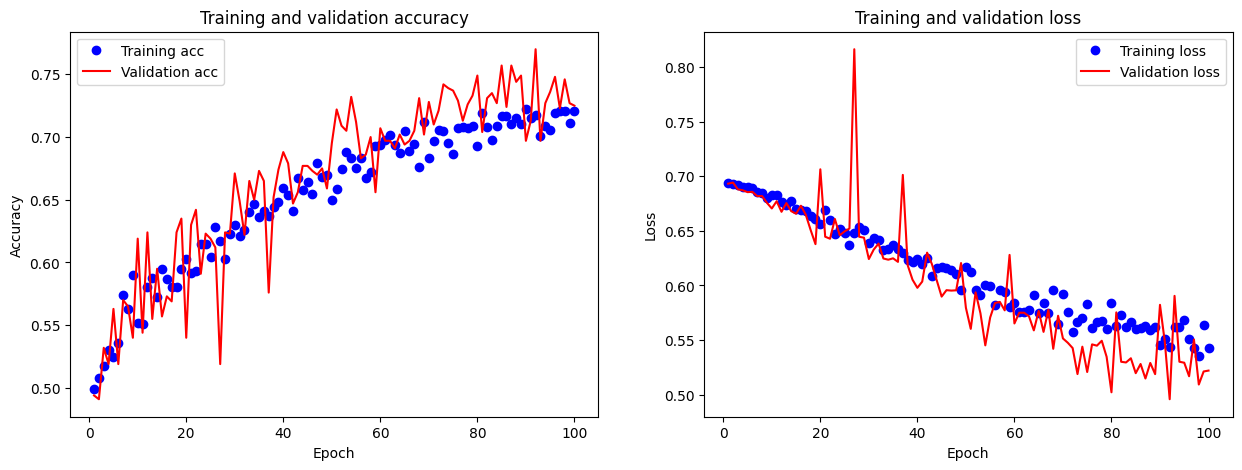

In [77]:
plot_history(baseline_ag_history_6k_add).savefig('output/plots/6k_baseline_ag_history_add.png')